In [1]:
# Set new current working directory path
import os
from pathlib import Path

os.chdir(Path.cwd().parent)
print('CWD After: ', Path.cwd())

CWD After:  /home/rivlanm/projects/nist_ppfl/NIST_PPFL_problem1_202503


In [26]:
import numpy as np
import pandas as pd
import pickle as pkl
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import matplotlib.pyplot as plt

# ART membership inference helper methods 
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import PyTorchClassifier

# pre trained models 
from problem1.attack_targets.cnn.model import Net as cnn_Net
from problem1.attack_targets.dpcnn10.model import Net as dpcnn10_Net
from problem1.attack_targets.dpcnn200.model import Net as dpcnn200_Net

# helper methods
from utils import *


## NIST Genomics PPFL Red Team Exercise
### Introductory tutorial for performing Membership Inference Attack on CNN trained on Soybean Genomics data


In [ ]:
MODEL_TYPE = 'dpcnn'  # or 'dpcnn'
PRIVACY_TYPE = 'dpcnn200'  # 'cnn' (no privacy), 'dpcnn10' (epsilon 10), dpcnn200 (epsilon 200)

In [ ]:
# Competitor should change these values to train the attack on different client models.
# To attack different clients competitors can change the client_id.  
# Competitors can change the model_type and privacy_type to test on different privacy levels. 

CLIENT_ID = '4'  # or '1', '2', '3'


# Client model directory path
model_dir = Path(f'problem1/attack_targets/{PRIVACY_TYPE}/client_{CLIENT_ID}')
# Client model (.torch) path
model_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}.torch')
# Path to relevant records data file for the client model
relevant_data_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_relevant_records.dat')
# Path to external records data file for the client model
external_data_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_external_records.dat')
# Path to challenge records data file for the client model
challenge_data_path = Path(model_dir.parent, f'{PRIVACY_TYPE}_challenge_records.dat')
# Path to hyperparameters file for the client model
hyperparameters_path = Path(model_dir, f'{MODEL_TYPE}_{CLIENT_ID}_hyperparameters.json')

In [ ]:


# Relevant records are those which an attacker might believe belongs to the client model. 
rel_x, rel_y = load_data(relevant_data_path)
print("shape, relevant records: {}".format(rel_x.shape))

# External records are those which an attacker believes do not belong to the client model. See problem statement for details.
ext_x, ext_y = load_data(external_data_path)
print("shape, external records: {}".format(ext_x.shape))

# Challenge records are those for which the competitor need to classify. 
#   Each challenge record can be classified into 5 categories.
#   If a challenge record belongs to the client model, the competitor should classify it as the client number (1, 2, 3, or 4). 
#   Otherwise, the competitor should classify it as 0 --> which means the record does not belong to any client model in the selected privacy level / privacy type.
challenge_x, challenge_y = load_data(challenge_data_path)
print("shape, challenge records: {}".format(challenge_x.shape))



shape, relevant records: (23, 125766)
shape, external records: (20, 125766)
shape, challenge records: (73, 125766)


In [ ]:

if PRIVACY_TYPE == "cnn":
    model_class = cnn_Net
elif PRIVACY_TYPE == "dpcnn10":
    model_class = dpcnn10_Net
elif PRIVACY_TYPE == "dpcnn200":
    model_class = dpcnn200_Net
else:
    raise ValueError("invalid model type")

task_model = load_model(model_path=model_path, 
                        num_data_features=rel_x.shape[1], 
                        model_class=model_class)

# These are hyperparameters used for training the client model
hyperparams = load_hyperparameters(hyperparameters_path)

# Define loss and other required hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer_name = hyperparams['optimizer']
learning_rate = hyperparams['learning rate']
weight_decay = hyperparams['weight decay']
num_classes = hyperparams['total classes']

# Wrap client model in the ART PyTorch classifier

# Select optimizer
if optimizer_name == 'sgd':
    optimizer = optim.SGD(task_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:
    optimizer = optim.Adamax(task_model.parameters(), lr=learning_rate,  weight_decay=weight_decay)

# Wrap client model in PyTorchClassifier
classifier = PyTorchClassifier(
    model=task_model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(rel_x.shape[1],),
    nb_classes=num_classes
    )

# Membership Inference Attack model hyperparameters
attack_model_type = 'nn'
attack_model_epochs = 100
attack_model_batch_size = 100
attack_model_learning_rate = 0.03

# Create Membership Inference Black Box attack object
attack_model = MembershipInferenceBlackBox(
    # this is an initialized version of Client N's classification model
    classifier,
    # attack model will be a nn
    attack_model_type=attack_model_type,
    # 100
    nn_model_epochs=attack_model_epochs,
    # 100
    nn_model_batch_size=attack_model_batch_size,
    # 0.03
    nn_model_learning_rate=attack_model_learning_rate
)

In [ ]:
# Get client model's predictions on relevant and external data
rel_x_preds = task_model(rel_x).squeeze()
ext_x_preds = task_model(ext_x).squeeze()
rel_x_preds = rel_x_preds.detach().numpy()
ext_x_preds = ext_x_preds.detach().numpy()

# Train attack model by passing relevant set as x and external set as test_x
attack_model.fit(
    # features from relevant records 
    x=rel_x,
    # outcome (soybean class) labels from relevant records
    y=rel_y,
    # features from external records
    test_x=ext_x,
    # outcome (soybean class) labels from external records
    test_y=ext_y,
    # prediction (logits) from pre trained classifier (for a given client) on relevant records 
    pred=rel_x_preds,
    # prediction (logits) from pre trained classifier (for a given client) on external records 
    test_pred=ext_x_preds
)

# evaluate challenge records 
challenge_pred = attack_model.infer(x=challenge_x, y=challenge_y, probabilities=True)


In [15]:
# evaluate challenge records 
challenge_pred = attack_model.infer(x=challenge_x, y=challenge_y, probabilities=True)


<Axes: >

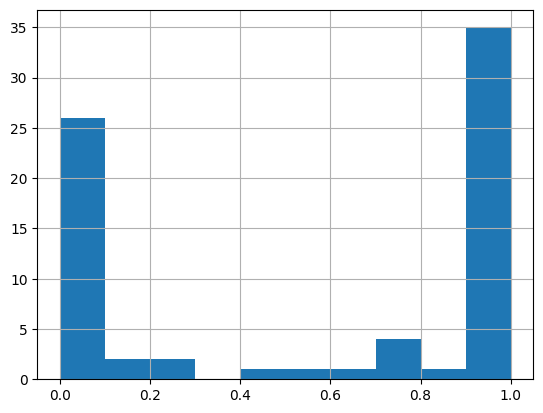

In [28]:
pd.Series(challenge_pred.reshape(1,-1)[0]).hist()

Note on Data Submission:

The list above contains the indices of the challenge records that the attack model has identified as potential members of the client_id task model. If you believe these indices correspond to actual member records of the tested client model, you should enter it as your prediction for that challenge record in the problem's submission_file.

The submission file consists of two columns: 1) INDEX 2) PREDICTION 

the first column is the challenge record index, and the second column is the prediction. If you believe the record was a member of some client's training data, enter the client number (1, 2, 3, 4) . However, if you determine that a challenge data index does not belong to any client model, enter '0' as the prediction for that index.

submission link

https://docs.google.com/forms/d/e/1FAIpQLSfGlDfuaDCJfId3Lv_45V5F4oYswUaulyGMVn_CD55_cRieQw/viewform

In [ ]:
# assign to client 1, 2, 3, 4, or none (0)

# Evaluate Example 

Challenge data answers are only provided for client_id 4.

In [ ]:
# Infer membership on relevant and external data
atk_rel_preds = attack_model.infer(x=rel_x, y=rel_y)
atk_ext_preds = attack_model.infer(x=ext_x, y=ext_y)

# retrieve confidence from inferencae
# infer_preds = atk_m.infer(x=tx, y=ty, probabilities=True)

# external data for an attack model only has non-members records.
# Find the number of non-members predicted by the attack model
external_correct = np.sum((atk_ext_preds == 0))

# Calculate accuracy on external data
external_accuracy = external_correct / len(atk_ext_preds)

print('Attack Model Accuracy on External Data: ', round(external_accuracy, 2))

In [ ]:
# Challenge data answers are only provided for client_id 4.